In [50]:
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
block_size = 8
batch_size = 4

mps


In [51]:
# train a transformer, bigram language model on this txt file
'''
A bigram language model is a type of statistical language model that predicts the probability of a word in a sequence based
on the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering
a specific word given the preceding word in a text or sentence.

A transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential
data like the words in this sentence
'''

'\nA bigram language model is a type of statistical language model that predicts the probability of a word in a sequence based\non the previous word. It considers pairs of consecutive words (bigrams) and estimates the likelihood of encountering\na specific word given the preceding word in a text or sentence.\n\nA transformer model is a neural network that learns context and thus meaning by tracking relationships in sequential\ndata like the words in this sentence\n'

In [52]:
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text)) # all characters in the text feild
print(chars)
print(len(chars))

vocab_size = len(chars)
# we're gonna use a tokenizer
# enocder -> each element of the chars array into an integer

['\t', '\n', ' ', '!', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Æ', 'Ç', 'É', 'à', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'œ', '—', '‘', '’', '“', '”', '…', '\ufeff']
101


In [53]:
string_to_int = {ch:i for i, ch in enumerate(chars)}
int_to_string = {i:ch for i, ch in enumerate(chars)}

encode = lambda s : [string_to_int[c] for c in s]
decode = lambda l: ''.join(int_to_string[i] for i in l)

# encode('hello hi')
# decode(encode('hello hi'))

data = torch.tensor(encode(text), dtype=torch.long) # long seq of integers

len(data)


5359346

In [54]:
encoded = encode(text)

# small vocab but lot of characters to work with
# being efficient with data is important

In [55]:
decode(encoded)

"\ufeffThe Complete Works of William Shakespeare\n\nby William Shakespeare\n\n\n\n\n                    Contents\n\n    THE SONNETS\n    ALL’S WELL THAT ENDS WELL\n    THE TRAGEDY OF ANTONY AND CLEOPATRA\n    AS YOU LIKE IT\n    THE COMEDY OF ERRORS\n    THE TRAGEDY OF CORIOLANUS\n    CYMBELINE\n    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK\n    THE FIRST PART OF KING HENRY THE FOURTH\n    THE SECOND PART OF KING HENRY THE FOURTH\n    THE LIFE OF KING HENRY THE FIFTH\n    THE FIRST PART OF HENRY THE SIXTH\n    THE SECOND PART OF KING HENRY THE SIXTH\n    THE THIRD PART OF KING HENRY THE SIXTH\n    KING HENRY THE EIGHTH\n    THE LIFE AND DEATH OF KING JOHN\n    THE TRAGEDY OF JULIUS CAESAR\n    THE TRAGEDY OF KING LEAR\n    LOVE’S LABOUR’S LOST\n    THE TRAGEDY OF MACBETH\n    MEASURE FOR MEASURE\n    THE MERCHANT OF VENICE\n    THE MERRY WIVES OF WINDSOR\n    A MIDSUMMER NIGHT’S DREAM\n    MUCH ADO ABOUT NOTHING\n    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE\n    PERICLES, PRINCE OF TY

In [56]:
data[:100]

tensor([100,  44,  61,  58,   2,  27,  68,  66,  69,  65,  58,  73,  58,   2,
         47,  68,  71,  64,  72,   2,  68,  59,   2,  47,  62,  65,  65,  62,
         54,  66,   2,  43,  61,  54,  64,  58,  72,  69,  58,  54,  71,  58,
          1,   1,  55,  78,   2,  47,  62,  65,  65,  62,  54,  66,   2,  43,
         61,  54,  64,  58,  72,  69,  58,  54,  71,  58,   1,   1,   1,   1,
          1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,  27,  68,  67,  73,  58,  67,  73,
         72,   1])

In [57]:
'''block_size = 8

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'When context is {context}, target is {target}')'''

"block_size = 8\n\nx = train_data[:block_size]\ny = train_data[1:block_size+1]\n\nfor t in range(block_size):\n    context = x[:t+1]\n    target = y[t]\n    print(f'When context is {context}, target is {target}')"

In [58]:
# validation and training splits

n = int(0.8 * len(data))

train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    # random index between 0 and len of data - block size, to start generating from
    ix = torch.randint(len(data) - block_size, (batch_size,))
    print(ix)
    #  stack, stacks the blocls together == to the batch size ie 4 in our case
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

get_batch('train')

tensor([4047564, 2585921,  247019, 3188556])


(tensor([[11,  1, 44, 61, 58, 71, 58,  2],
         [ 9,  2, 73, 68,  2, 58, 77, 54],
         [54, 72, 62, 68, 67,  9,  2, 65],
         [37, 33, 25, 11,  1, 36, 68, 76]], device='mps:0'),
 tensor([[ 1, 44, 61, 58, 71, 58,  2, 62],
         [ 2, 73, 68,  2, 58, 77, 54, 66],
         [72, 62, 68, 67,  9,  2, 65, 58],
         [33, 25, 11,  1, 36, 68, 76, 58]], device='mps:0'))

## sample Probability distribution table
logits
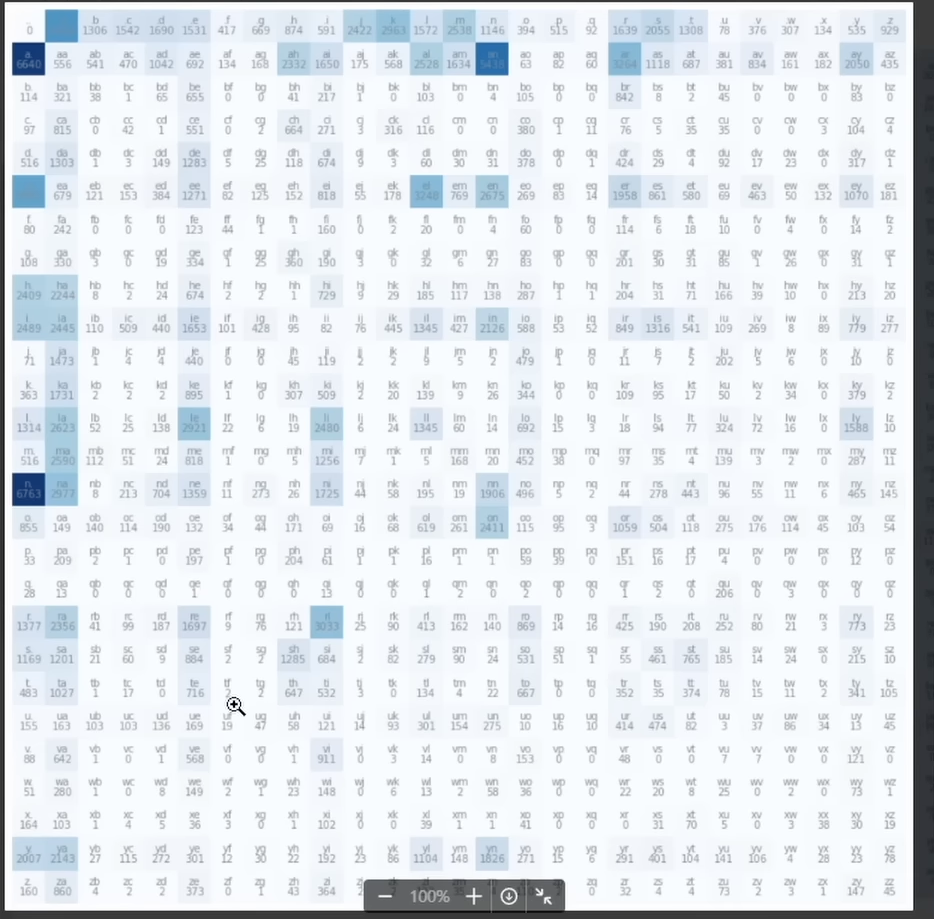

In [59]:
class BigramLanguageModel(nn.Module):
    # it is a subclass of nn.module, inherits
    def __init__(self, vocab_size):
        # to call the constructor of its parent class.
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        # embdding -> continuous vector represntation of discrete items
    
    def forward_pass(self, index, targets=None):
        # logits -> probabilty 
        # batch, time, channel -> vocab size
        # time dimesion is what we dont know 
        '''
        a "token embedding table" refers to a table or matrix that contains the embedding vectors for
        each token (word or subword) in the vocabulary.
        '''
        '''
        The view method in PyTorch is used to reshape a tensor.
        It returns a new tensor with the same data but a different shape.
        The purpose of using logits.view(B * T, C) in the provided code is to reshape the logits tensor,
        combining the batch and time dimensions into a single dimension.
        '''
        '''
        The "batch" dimension refers to the number of sequences (or data samples) processed in parallel during
        one iteration of training or inference.
        The "time" dimension typically represents the length of the input sequences or the number of time steps in a sequence.
        In the context of a bigram model, this could be thfe length of the sequences of tokens or words.
        In NLP (Natural Language Processing) or sequence modeling,
        each word or token is often represented as a vector (embedding),
        and the "channel" dimension corresponds to the dimensionality of this vector.
        '''
        logits = self.token_embedding_table(index)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # batch and time can be blended together          
            # why reshape -> for calculating loss in the cross entropy function  
            loss = F.cross_entropy(logits, targets)
            # calculating loss lol, diffrerence between logits and targets
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # were gonnna generate max new tokens no of tokens
        for _ in range(max_new_tokens):
            logits, loss = self.forward(index)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            # probs are the probabilities of each token, multinomial basically converts these probabilites to actual values in this case predcts the one index
            index = torch.cat((index, index_next), dim=1) # (b, t+1)
        return index
    

